# 09.01 Trees

Before we attempt to describe how one uses several models at once
to solve a single problem we need to take a step back and look
at a rather simple but still useful model, the **decision tree**.

![Major Oak](sl-major-oak.svg)

<div style="text-align:right;"><sup>sl-major-oak.svg</sup></div>

<div style="border: 0.3em double teal; border-radius: 0.5em; padding:0.5em;">
    The Royal Oak is a major Oak tree in Sherwood Forest.
    Legend says that Robin Hood and his band of Merry Men had their hideout
    below the tree.
    The Oak itself is at least 800 years old which makes it viable for it
    to be alive and reasonably grown during the time the legendary folk
    hero supposedly lived.
    Whether Robin Hood himself lived or whether his tales are a collection
    of stories aggregated from the deeds of many people remains unsolved.
    One thing we can say rather confidently about Robin Hood is that he
    very likely did wear green clothes.
    In the 13th century hunters in the forests in the Midlands used clothes
    dyed in Lincoln, which was famous for green dyes.
</div>

For a start we import the usual stuff.
We will again use the moons dataset creator and take the decision
tree classifier to work on a non-linear problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

Two moons are a non-linear problem but we can produce a more complex
problem by merging two two moons datasets into a four moon dataset.
The decision tree is a model which can separate several classes at once,
and with four moons we have four distinct classes.

Note that we moved the second set of moons to the right by adding $3$ to it.
And that we also add to the labels of the second set of moons in order
to have four different classes.

In [2]:
def make_four_moons(n, noise):
    X_left, y_left = make_moons(n//2, noise=noise)
    X_right, y_right = make_moons(n//2, noise=noise)
    X_right[:, 0] += 3
    y_right[:] += 2
    X = np.vstack((X_left, X_right))
    y = np.hstack((y_left, y_right))
    return X, y

Let's have a look how this turns out.

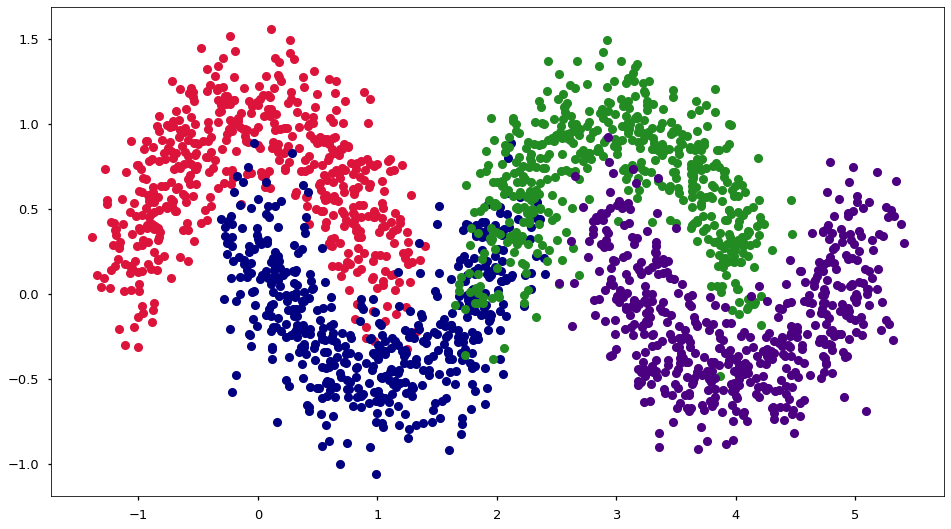

In [3]:
X, y = make_four_moons(2048, noise=.2)
fig, ax = plt.subplots(figsize=(16, 9))
colors = ['crimson', 'navy', 'forestgreen', 'indigo']
for i in range(4):
    ax.plot(X[y == i, 0], X[y == i, 1], 'o', c=colors[i])

A decision tree is a rather simple non-parametric model,
either used as a classifier or a regressor.
During training a decision tree learns rules that divide
the feature space *perpendicular* to a feature.
In other words, at each training step,
the tree divides one dimension into two groups.

At the first training step the tree divides the entire feature space.
On all following steps the tree attempt to divide each resulting divided branch further.
This happens until all leaves contain only data with the same label,
or another stopping criteria is reached.
A handful of stopping criteria can be the depth (or height) of the tree,
which limits how many times the tree can split;
the minimum number of data points in a leaf,
which is the smallest possible split produced by a tree.

There are several algorithms to train a decision tree.
The algorithms are concerned in how, at each step, perform the best split.
At each step a tree can split the feature space into two separate areas using any of the features.
Therefore each feature is evaluated for the best split so that as many labels are separated,
then an information gain measure is used to decide which split produces the tree that better
slits classes apart.
The information gain measure differs between algorithms,
for classification we have a handful of information measures.

Take the split which minimizes the *gini* impurity,

$$
\sum_k \left[ \frac{\sum_i (y_i = k)}{N} \left( 1 - \frac{\sum_i (y_i = k)}{N} \right) \right]
$$

or, take the split which minimizes the *entropy*

$$
\sum_k \left[ - \frac{\sum_i (y_i = k)}{N} log \left( \frac{\sum_i (y_i = k)}{N} \right) \right]
$$

or even the split which minimizes the maximum misclassification error.

$$
\sum_k \left[ 1 - max \left( \frac{\sum_i (y_i = k)}{N} \right) \right]
$$

Where $k$ is each class and $N$ the number of samples being split.
For regression criteria such as mean square error can be used.

Once a tree performs a split then the division is set in stone.
Each side of the split is then evaluated for more splits
taking into account only the data points that are inside that split.
In other words, once a tree has split the dataset into two parts
(splits) each part (split) is considered a new complete dataset
and a new decision tree split is performed on it as if it were a new tree.
The final complete tree is a connection of all these splits into a branched structure.

No matter the split method the algorithm is always a greedy algorithm.
The tree will always attempt the split that will reduce the impurity/entropy
the most *at the current step*.
By no means this guarantees that the final tree will be optimal,
or have the minimum overall impurity/entropy.

In general decision trees tend to overfit the data.
The stopping criteria are ways of making the tree not overfit the data
but the best criteria can be hard to find, i.e. by hyperparamter search.
Without any criteria we will just split the data as much as we can.

We have the data and we know something about decisions trees.
Other than the internals of the model,
in `sklearn` trees work with the same `fit` and `predict` methods.

In [4]:
model = DecisionTreeClassifier()
cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True))

array([0.90731707, 0.91707317, 0.9195122 , 0.91198044, 0.9193154 ])

Good enough for such a simple classifier.
As most `sklearn` classes the decision tree classifier has some sensible defaults.

Decision trees are simple and computationally cheap to use for multilabel classification,
also this is a model that can estimate class probabilities.
We can also extract the rules the tree has learned to explain what it is doing.
In other words, the decision tree is a white-box model,
a model that can explain how it performs the classification.

We can look at how the classification happened.
In the plot we use color maps in two ways.
In one we assign `cmap=` and the engine figures out that it needs
to split the color in four different hues.
Another way to do it is to take the color map from the `cm`
module and execute it with color an array of values between $0$ and $1$.
Also, there are more efficient ways to plot an entire canvas of color,
with contour and filled contours procedures from `matplotlib`.
But when it doubt the trick of plotting many semi-transparent
points - as we do here - make it easier to spot visualization mistakes.

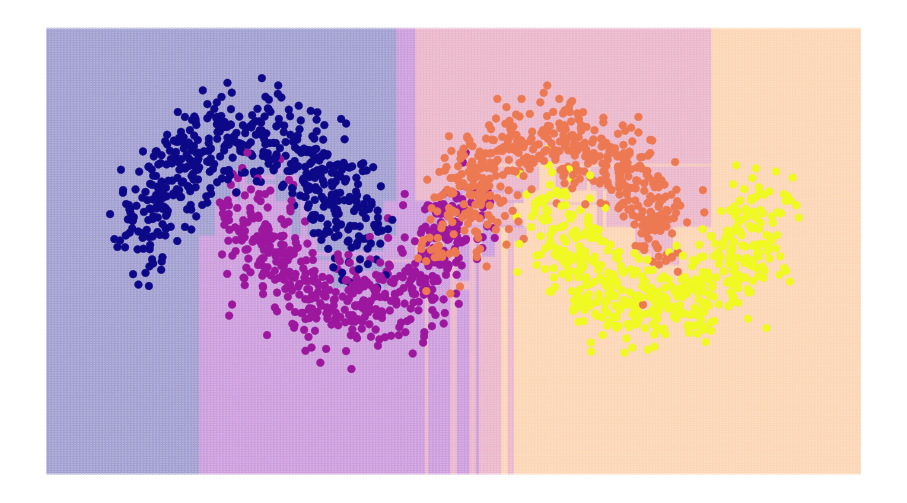

In [5]:
model = DecisionTreeClassifier()
model.fit(X, y)

fig, ax = plt.subplots(figsize=(16, 9))
gx = np.linspace(-2, 6, 256)
gy = np.linspace(-2, 2, 256)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)
z = model.predict(np.c_[gx, gy])
ax.scatter(gx, gy, c=plt.cm.plasma(z / 4), alpha=0.2, s=10)
ax.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap='plasma')
ax.axis('off');

And we can see a lot of overfitting in the middle of the figure.
Since the data is two dimensional we can visualize it and argue
for specific stopping conditions.
I here a good choice would be to not allow leaves with less than,
say, $10$ data points.

Unfortunately, as we did see, visualizing a dataset can be quite hard.
Soon we will see how to avoid the a good deal of the overfitting
without the need for visualization.
For the time being let's look at how the decision tree decided to split the data.
The `max_depth=` hyperparamter is a stopping criteria,
and we will use it to build our tree by parts.

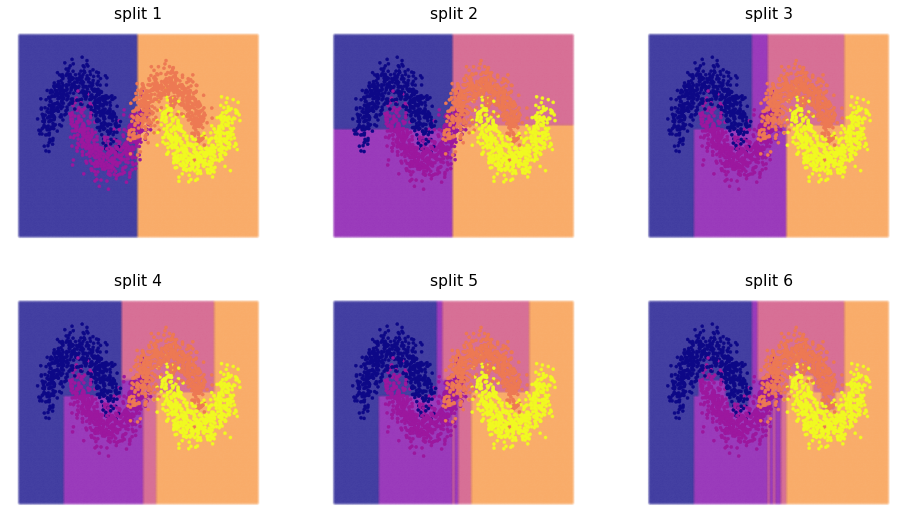

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
gx = np.linspace(-2, 6, 256)
gy = np.linspace(-2, 2, 256)
gx, gy = np.meshgrid(gx, gy)
gx, gy = gx.reshape(-1), gy.reshape(-1)

for i in range(6):
    model = DecisionTreeClassifier(max_depth=i+1)
    model.fit(X, y)
    z = model.predict(np.c_[gx, gy])
    ax.flat[i].scatter(gx, gy, c=plt.cm.plasma(z / 4), alpha=0.1, s=10)
    ax.flat[i].scatter(X[:, 0], X[:, 1], s=10, c=y, cmap='plasma')
    ax.flat[i].set_title('split %s' % (i+1))
    ax.flat[i].axis('off')

In the first split the tree divides in the middle across the horizontal feature.
It produces a left and a right leaf.  For now this is a tiny tree.
In the second split the left part is divided in the middle across the vertical
feature and the same happens with the right side.

We will now ignore the right side and continue looking at the left side only.
In the third split the bottom-left has been divided into two across
the horizontal feature, between the blue and violet classes.
Still in the third split the top-left is also divided
across the horizontal feature so that the far right side
of the current split is moved to the violet class.

Now we will look only at the top-left and ignore the remaining regions.
In the third split the far right of this part was violet
but in the fourth split it is divided between the violet and the orange.
The resulting small violet strip now only has a single (violet)
data point and splitting on this part finishes since the part is *pure*.
But still in the fourth split the left side is split
between the far left fully blue (pure) and the middle of blues and violet.
We cannot see this last split in the graph but we can guess that it happens
based on how the tree evolves further.

In the fifth split the only two not pure parts in the top left
are again split vertically.
One becomes pure orange and pure violet parts and
the other becomes pure blue and mixed blue and violet.
In the final sixth split the remaining non pure part in the
top-left is split horizontally into a blue and a violet part.
Similar splitting happen in the other parts of the graph.

Decision trees are very sensitive to outliers and variations in data.
Hence running the data generation several times may result in slightly different splits.

Other limitations also plague decision trees.
For example, one needs to ensure that data fed to a decision tree is scaled and has similar
support across all classes as trees tend to be biased to the most often found classes.